## LGT1 Unit 3 Day 12

Today we are going to use the Grid Python Toolkit(gpt) library by Cristoph Lehner to investigate Wilson fermions, mass fine tuning, and fermion correlation functions. 

Just to write them here, the parts which require you to fill something out are 
 - Write the kinetic term of the Wilson Dirac operator
 - calculate the pion correlator, and plot the effective mass of the pion
 - Using the data for the input quark masses and the calculated effective pion masses, calculate the critical mass by a linear fit of the data

If there ever is the need to use a built in gpt function, I will tell you what it is and what its arguments are.

In [1]:
import gpt as g
import numpy as np
import matplotlib.pyplot as plt

### Configuration generation

Run this cell to create a 8c32 configuration to use for today's exercise

In [3]:
#create 1 config
L = [8,8,8,32]
Ls = 8
Lt = 32
grid = g.grid(L, g.single)
grid_eo = g.grid(L, g.single, g.redblack)

rng = g.random("test", "vectorized_ranlux24_24_64")
U = g.qcd.gauge.unit(grid)
Nd = len(U)

# red/black mask
mask_rb = g.complex(grid_eo)
mask_rb[:] = 1
# full mask
mask = g.complex(grid)

# simple plaquette action
def staple(U, mu):
    st = g.lattice(U[0])
    st[:] = 0
    Nd = len(U)
    for nu in range(Nd):
        if mu != nu:
            st += g.qcd.gauge.staple(U, mu, nu) / U[0].otype.Nc
    return st
    
beta = 5.5

g.default.push_verbose("su2_heat_bath", False)
markov = g.algorithms.markov.su2_heat_bath(rng)
U = g.qcd.gauge.unit(grid)
plaquette_heatbath = []
for it in range(250):
    plaq = g.qcd.gauge.plaquette(U)
    plaquette_heatbath.append(plaq)
    if it % 50 == 0:
        g.message(f"SU(2)-subgroup heatbath {it} has P = {plaq}")
    for cb in [g.even, g.odd]:
        mask[:] = 0
        mask_rb.checkerboard(cb)
        g.set_checkerboard(mask, mask_rb)

        for mu in range(Nd):
            st = g.eval(beta * staple(U, mu))
            markov(U[mu], st, mask)

GPT :      10.195157 s : Initializing gpt.random(test,vectorized_ranlux24_24_64) took 0.000302792 s
GPT :      10.275601 s : SU(2)-subgroup heatbath 0 has P = 1.0
GPT :      24.304476 s : SU(2)-subgroup heatbath 50 has P = 0.5016584396362305
GPT :      44.523818 s : SU(2)-subgroup heatbath 100 has P = 0.49897437625461155
GPT :      68.482410 s : SU(2)-subgroup heatbath 150 has P = 0.49731948640611434
GPT :      83.901509 s : SU(2)-subgroup heatbath 200 has P = 0.49608691533406574
GPT :     105.138474 s : SU(2)-subgroup heatbath 250 has P = 0.4999668863084581
GPT :     123.820985 s : SU(2)-subgroup heatbath 300 has P = 0.49857166078355575
GPT :     123.826647 s : Switching view to [1,1,1,1]/Write
GPT :     123.839345 s : Wrote 0.00109863 GB at 0.0863957 GB/s (0.111668 GB/s for distribution, 1.80777 GB/s for checksum, 1.51979 GB/s for writing, 1 views per node)
GPT :     123.845089 s : Wrote 0.00109863 GB at 0.225352 GB/s (0.861469 GB/s for distribution, 0.377272 GB/s for checksum, 1.677

Below we define a Wilson Dirac operator. I have left the kinetic term out for you to fill in. 

### Wilson Dirac operator and pion correlator

In [4]:
#gamma matrices
print("gamma[1] =\n",g.gamma[0].tensor().array)
print("gamma[2] =\n",g.gamma[1].tensor().array)
print("gamma[3] =\n",g.gamma[2].tensor().array)
print("gamma[4] =\n",g.gamma[3].tensor().array)
print("gamma[5] =\n",g.gamma[5].tensor().array)

gamma[1] =
 [[ 0.+0.j  0.+0.j  0.+0.j  0.+1.j]
 [ 0.+0.j  0.+0.j  0.+1.j  0.+0.j]
 [ 0.+0.j -0.-1.j  0.+0.j  0.+0.j]
 [-0.-1.j  0.+0.j  0.+0.j  0.+0.j]]
gamma[2] =
 [[ 0.+0.j  0.+0.j  0.+0.j -1.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [-1.+0.j  0.+0.j  0.+0.j  0.+0.j]]
gamma[3] =
 [[ 0.+0.j  0.+0.j  0.+1.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -0.-1.j]
 [-0.-1.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+1.j  0.+0.j  0.+0.j]]
gamma[4] =
 [[0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]]
gamma[5] =
 [[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j]]


In [4]:
Uapt = g.copy(U)
# anti-periodic fermion in time can be achieved modifying last link in time
Uapt[3][:,:,:,grid.gdimensions[3]-1] *= -1

def DiracWilson(U, src, m):
    dst = g((4.0 + m) * src) #mass term
    for mu in range(4):
        #Kinetic term. Note you must use covariant shift functions g.cshift(src,dir,len)
        #gpt also has a built in adjoint function g.adj(M)
        #also make sure that your expressions are in this g() function. 
        fmu = g() #forward derivative term
        bmu = g() #backward derivative term

        #put it all together here 
        
    return dst

#this generates random quark fields and tests the gamma5 Hermiticity, and tests that the norm is real. Your Dirac operator
#is gamma5 Hermitian if the first two numbers are the same, and check that the third number has a near zero imaginary part. 
rng = g.random("13")
a, b = rng.cnormal([g.vspincolor(grid),g.vspincolor(grid)]) #defines two random quark fields
# test gamma5 hermiticity
print(g.inner_product(b, g.gamma[5] * DiracWilson(Uapt, a, -0.5)))
print(g.inner_product(a, g.gamma[5] * DiracWilson(Uapt, b, -0.5)).conjugate())
# norm real
print(g.inner_product(a, g.gamma[5] * DiracWilson(Uapt, a, -0.5)))

GPT :     827.101506 s : Initializing gpt.random(13,vectorized_ranlux24_389_64) took 0.00014329 s
(312.2275570382616+4365.117751981628j)
(312.2279762047615+4365.116901796602j)
(1418.6184790119203+3.4729264257293835e-05j)


In order to calculate a correlation function, we need to invert the Dirac operator we just created. This is one method to do so, the Flexible
Generalized Minimal RESidual(fgmres) algorithm to invert our operator. Note $\gamma_5D\gamma_5 = D^{\dagger}$,so we we want to invert that instead of just $D$

In [5]:
g.default.set_verbose("fgmres_convergence", False)
inv = g.algorithms.inverter.fgmres(eps = 1e-8, maxiter = 400)

In [6]:
#defines the gamma_5 Wilson Dirac operator. 
def G5DiracWilson(dst, src):
    dst @= g.gamma[5] * DiracWilson(Uapt, src, -0.5)
    return dst

invG5D = inv(G5DiracWilson)

In [7]:
src = g.mspincolor(grid)
g.create.point(src, [0, 0, 0, 0])

lattice(ot_matrix_spin_color(4,3),single)

In [8]:
#dst here is our inverse. This is what we will use to define a correlation function. 
dst = g(invG5D * g.gamma[5] * src)

GPT :     871.178560 s : fgmres: converged in 376 iterations;  computed squared residual 1.093025e-15 / 1.200000e-15;  true squared residual 7.237462e-14 / 1.200000e-15


Now that we have the inverse we want, define the pion correlator in the next cell. Recall 
$$
\langle \hat{O}_{\pi}(t)\hat{O}_{\pi}^{\dagger}(0)\rangle = \sum_{x,y}\langle \text{Tr}[D^{-1}(U)_{\vec{x},t;0,0}(D^{-1}(U)_{\vec{x},t;0,0})^{\dagger}]\rangle
$$

In [1]:
#You will want to use two gpt functions here, g.slice(M,axis) to take the time slice (averages over spatial components), 
#and g.trace(M) to compute the trace. 

Ct = #expression for correlation function goes here


SyntaxError: invalid syntax (1026812842.py, line 3)

Plot the effective mass of the pion, given by an expression similar to how the static quark potential was defined, 
$$ m_{eff,\pi} = \text{ln}\frac{C(t)_{\pi}}{C(t+1)_{\pi}}$$
(no special gpt functions are needed here)

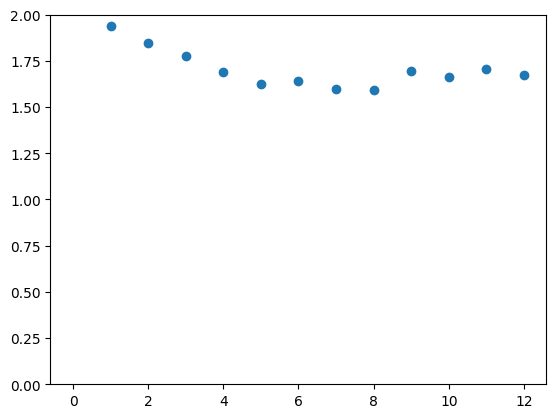

In [10]:

#plot the effective mass here. 


### Mass fine tuning

Now we want to demonstrate an example of mass fine tuning to make Wilson fermions chiral. If we had exact chiral symmetry, the pion would be an exact Goldstone boson of the theory. So what we want to do is find a value of the quark mass, the mass of the Wilson fermions, that get us to that limit. 

In [14]:
#We now define Wilson fermions using the built in gpt functionality
w = g.qcd.fermion.wilson_clover(U,mass=-0.5, csw_r=0.0, csw_t=0.0, nu=1.0, xi_0=1.0,isAnisotropic=False,boundary_phases=[1,1,1,-1])

#this line checks the difference of the previously defined Wilson operator and the gpt defined one. This should be small
print("Test D:", g.norm2(w(b) - DiracWilson(Uapt,b,-0.5)))

#we use a more efficient inverting algoritm now, the conjugate gradient method. 
inv = g.algorithms.inverter
pc = g.qcd.fermion.preconditioner
g.default.set_verbose("cg_convergence",False)
cg = inv.cg({"eps":1e-6, "maxiter":1000})
invD = w.propagator(inv.preconditioned(pc.eo1_ne(),cg))

#dst2 is our quark propagator for this new Wilson operator.
dst2 = g(invD * src)

#This checks the difference between the propagators
print("Test D^{-1}:",g.norm2(dst-dst2)/g.norm2(dst2))

Test D: 4.9434384928430386e-08
GPT :    1440.121496 s : cg: converged in 31 iterations
GPT :    1440.179521 s : cg: converged in 31 iterations
GPT :    1440.244258 s : cg: converged in 32 iterations
GPT :    1440.305615 s : cg: converged in 31 iterations
GPT :    1440.368030 s : cg: converged in 31 iterations
GPT :    1440.430347 s : cg: converged in 31 iterations
GPT :    1440.492722 s : cg: converged in 32 iterations
GPT :    1440.555052 s : cg: converged in 31 iterations
GPT :    1440.615066 s : cg: converged in 32 iterations
GPT :    1440.676816 s : cg: converged in 31 iterations
GPT :    1440.738984 s : cg: converged in 32 iterations
GPT :    1440.803238 s : cg: converged in 31 iterations
Test D^{-1}: 5.266828203712478e-12


In [17]:
#we now define a function that will calculate the pion effective mass for an input list of different Wilson fermion masses. 
def effective_mass_pion_single_config(m):
    w = g.qcd.fermion.wilson_clover(U, mass=m, csw_r=0.0, csw_t=0.0, nu=1.0, xi_0=1.0,
                                    isAnisotropic=False,boundary_phases=[1,1,1,-1])
    invD = w.propagator(inv.preconditioned(pc.eo1_ne(), cg))
    dst = g(invD * src)
    Ct = g.slice(g.trace(g.adj(dst)*dst),3)
    return [np.log(Ct[t] / Ct[t+1]).real for t in range(13)]

#loops through the Wilson fermion masses and calculates the effective pion mass for all of them. 
emp = {}
for m in [-0.5, -0.6, -0.7, -0.8, -0.9, -1.0]:
    emp[m] = effective_mass_pion_single_config(m)

GPT :    1628.646620 s : cg: converged in 31 iterations
GPT :    1628.707702 s : cg: converged in 31 iterations
GPT :    1628.768658 s : cg: converged in 32 iterations
GPT :    1628.828470 s : cg: converged in 31 iterations
GPT :    1628.890213 s : cg: converged in 31 iterations
GPT :    1628.941562 s : cg: converged in 31 iterations
GPT :    1629.001561 s : cg: converged in 32 iterations
GPT :    1629.062196 s : cg: converged in 31 iterations
GPT :    1629.127903 s : cg: converged in 32 iterations
GPT :    1629.189233 s : cg: converged in 31 iterations
GPT :    1629.250474 s : cg: converged in 32 iterations
GPT :    1629.311605 s : cg: converged in 31 iterations
GPT :    1629.751889 s : cg: converged in 36 iterations
GPT :    1629.820266 s : cg: converged in 36 iterations
GPT :    1629.901682 s : cg: converged in 36 iterations
GPT :    1629.986330 s : cg: converged in 36 iterations
GPT :    1630.057644 s : cg: converged in 36 iterations
GPT :    1630.127387 s : cg: converged in 36 ite

In [2]:
quark_masses = []
pion_masses = []
pion_masses_err = []

#we fill lists of 
for m in emp:
    quark_masses.append(m)
    pion_masses.append(0.5*(emp[m][7] + emp[m][8]))
    pion_masses_err.append(0.5*(emp[m][7] - emp[m][8]))

SyntaxError: unterminated string literal (detected at line 15) (1949240068.py, line 15)

We now have the input quark masses, the effective pion masses, and their errors(single configuration). Plot this data, and use a linear fit to extrapolate backwards to find the so called 'critical mass', which is the input mass for which we have effectively zero pion mass, indicating chiral symmetry. 

In [33]:
fig, ax = plt.subplots()

#scipy isn't built in the gpt container so you can use np.polyfit to do the linear fit, and plt.axline to draw the fit line on the graph

#plot the fit line and the data in the same plot and then calculate the x intercept to find the critical mass

-1.7714202322269366
